# Learning and Decision Making

## Laboratory 4: Reinforcement learning

In the end of the lab, you should export the notebook to a Python script (``File >> Download as >> Python (.py)``). Make sure that the resulting script includes all code written in the tasks marked as "**Activity n. N**", together with any replies to specific questions posed. Your file should be named `padi-labKK-groupXXX.py`, where `KK` corresponds to the lab number and the `XXX` corresponds to your group number. Similarly, your homework should consist of a single pdf file named `padi-hwKK-groupXXX.pdf`. You should create a zip file with the lab and homework files and submit it in Fenix **at most 30 minutes after your lab is over**.

Make sure to strictly respect the specifications in each activity, in terms of the intended inputs, outputs and naming conventions.

In particular, after completing the activities you should be able to replicate the examples provided (although this, in itself, is no guarantee that the activities are correctly completed).

### 1. The MDP Model 

In this lab you will implement several reinforcement learning algorithms, and use the taxi domain from Lab 2 to test and compare these algorithms. Don't forget, however, that your functions should work for **any MDP** and not just the one provided. 

The taxi domain to be used is represented in the diagram below.

<img src="taxi.png" width="250px">

In the above domain, 

* The taxi can be in any of the 25 cells in the diagram. The passenger can be at any of the 4 marked locations ($Y$, $B$, $G$, $R$) or in the taxi. Additionally, the passenger wishes to go to one of the 4 possible destinations. The total number of states, in this case, is $25\times 5\times 4$.
* At each step, the agent (taxi driver) may move in any of the four directions -- south, north, east and west. It can also pickup the passenger or drop off the passenger. 
* The goal of the taxi driver is to pickup the passenger and drop it at the passenger's desired destination.

**Throughout the lab, unless if stated otherwise, use $\gamma=0.99$.**

$$\diamond$$

We start by loading the MDP for the taxi domain from the file `taxi.npz`. We will use this domain as an example to illustrate the different functions/algorithms you are expected to deploy. The file contains both the MDP, described as a tuple like those from Lab 2, and the corresponding optimal $Q$-function.

To do so, you can run the code
```python
import numpy as np

mdp_info = np.load('taxi.npz', allow_pickle=True)

# The MDP is a tuple (X, A, P, c, gamma)
M = tuple(mdp_info['M'])

# We also load the optimal Q-function for the MDP
Qopt = mdp_info['Q']
```

---

In the first activity, you will implement a "simulator of the world". The simulator consists of a function that enables you to sample a transition from a given MDP. You will then use this function, in subsequent activities, to generate the data that your agent will use to learn.

---

#### Activity 1.        

Write a function named `sample_transition` that receives, as input, a tuple representing an arbitrary MDP as well as two integers, `x` and `a`, corresponding to a state and an action. The function should return a tuple `(x, a, c, x')`, where `c` is the cost associated with performing action `a` in state `x` and `x'` is a state generated from `x` upon selecting action `a`, according to the transition probabilities for the MDP.

---

In [43]:
import numpy as np

def sample_transition(mdp, x, a):
    X = mdp[0]
    P = mdp[2]
    C = mdp[3]
    x_line = np.random.choice(len(X), p=P[a][x, :])
    return (x, a, C[x, a], x_line)

import numpy as np

mdp_info = np.load('taxi.npz', allow_pickle=True)

# The MDP is a tuple (X, A, P, c, gamma)
M = tuple(mdp_info['M'])

# We also load the optimal Q-function for the MDP
Qopt = mdp_info['Q']

import numpy.random as rnd

rnd.seed(42)

# Select random state and action
x = 175 # State (9, B, B)
a = rnd.randint(len(M[1]))

x, a, cnew, xnew = sample_transition(M, x, a)

print('Observed transition:\n(', end='')
print(M[0][x], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][xnew], end=')\n')

# Select random state and action
x = 187 # State (10, G, B)
a = rnd.randint(len(M[1]))

x, a, cnew, xnew = sample_transition(M, x, a)

print('\nObserved transition:\n(', end='')
print(M[0][x], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][xnew], end=')\n')

# Select random state and action
x = 69 # State (4, Y, G)
a = rnd.randint(len(M[1]))

x, a, cnew, xnew = sample_transition(M, x, a)

print('\nObserved transition:\n(', end='')
print(M[0][x], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][xnew], end=')\n')


Observed transition:
((9, B, B), West, 0.7, (8, B, B))

Observed transition:
((10, G, B), East, 0.7, (10, G, B))

Observed transition:
((4, Y, G), Pickup, 1.0, (4, Y, G))


All reinforcement learning algorithms that you will implement can only access the MDP through the function `sample_transition` which, in a sense, simulates an "interaction" of the agent with the environment.

For example, using the taxi MDP, you could run:

```python
import numpy.random as rnd

rnd.seed(42)

# Select random state and action
x = 175 # State (9, B, B)
a = rnd.randint(len(M[1]))

x, a, cnew, xnew = sample_transition(M, x, a)

print('Observed transition:\n(', end='')
print(M[0][x], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][xnew], end=')\n')

# Select random state and action
x = 187 # State (10, G, B)
a = rnd.randint(len(M[1]))

x, a, cnew, xnew = sample_transition(M, x, a)

print('\nObserved transition:\n(', end='')
print(M[0][x], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][xnew], end=')\n')

# Select random state and action
x = 69 # State (4, Y, G)
a = rnd.randint(len(M[1]))

x, a, cnew, xnew = sample_transition(M, x, a)

print('\nObserved transition:\n(', end='')
print(M[0][x], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][xnew], end=')\n')
```

and get, as output:

```
Observed transition:
((9, B, B), West, 0.7, (8, B, B))

Observed transition:
((10, G, B), East, 0.7, (10, G, B))

Observed transition:
((4, Y, G), Pickup, 1.0, (4, Y, G))
```

**Note:** For debug purposes, we also provide a second file, `taxi-small.npz`, that contains a 9-state MDP that you can use to verify if your results make sense.

---

#### Activity 2.        

Write down a function named `egreedy` that implements an $\epsilon$-greedy policy. Your function should receive, as input, a `numpy` array `Q` with shape `(N,)`, for some integer `N`, and, as an optional argument, a floating point number `eps` with a default value `eps=0.1`. Your function should return... 

* ... with a probability $\epsilon$, a random index between $0$ and $N-1$.
* ... with a probability $1-\epsilon$, the index between $0$ and $N-1$ corresponding to the minimum value of `Q`. If more than one such index exists, the function should select among such indices **uniformly at random**.

**Note:** In the upcoming activities, the array `Q` received by the function `egreedy` will correspond to a row of a $Q$-function, and `N` will correspond to the number of actions.

In [44]:
def egreedy(Q, eps=0.1):
    if np.random.rand() <= eps:
        return np.random.choice(len(Q))
    else:
        policy = np.isclose(Q, np.min(Q)).astype(int)
        probs = policy / np.sum(policy)
        return np.random.choice(np.arange(len(Q)), p=probs)
    
rnd.seed(42)

x = 175 # State (9, B, B)
a = egreedy(Qopt[x, :], eps=0)
print('State:', M[0][x], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[x, :], eps=0.5)
print('State:', M[0][x], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[x, :], eps=1.0)
print('State:', M[0][x], '- action (eps=1.0):', M[1][a])

x = 187 # State (10, G, B)
a = egreedy(Qopt[x, :], eps=0)
print('\nState:', M[0][x], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[x, :], eps=0.5)
print('State:', M[0][x], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[x, :], eps=1.0)
print('State:', M[0][x], '- action (eps=1.0):', M[1][a])

x = 69 # State (4, Y, G)
a = egreedy(Qopt[x, :], eps=0)
print('\nState:', M[0][x], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[x, :], eps=0.5)
print('State:', M[0][x], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[x, :], eps=1.0)
print('State:', M[0][x], '- action (eps=1.0):', M[1][a])

State: (9, B, B) - action (eps=0.0): South
State: (9, B, B) - action (eps=0.5): South
State: (9, B, B) - action (eps=1.0): East

State: (10, G, B) - action (eps=0.0): North
State: (10, G, B) - action (eps=0.5): East
State: (10, G, B) - action (eps=1.0): North

State: (4, Y, G) - action (eps=0.0): West
State: (4, Y, G) - action (eps=0.5): West
State: (4, Y, G) - action (eps=1.0): West


For example, using the function `Qopt` loaded from the taxi file, you can run:

```python
rnd.seed(42)

x = 175 # State (9, B, B)
a = egreedy(Qopt[x, :], eps=0)
print('State:', M[0][x], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[x, :], eps=0.5)
print('State:', M[0][x], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[x, :], eps=1.0)
print('State:', M[0][x], '- action (eps=1.0):', M[1][a])

x = 187 # State (10, G, B)
a = egreedy(Qopt[x, :], eps=0)
print('\nState:', M[0][x], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[x, :], eps=0.5)
print('State:', M[0][x], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[x, :], eps=1.0)
print('State:', M[0][x], '- action (eps=1.0):', M[1][a])

x = 69 # State (4, Y, G)
a = egreedy(Qopt[x, :], eps=0)
print('\nState:', M[0][x], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[x, :], eps=0.5)
print('State:', M[0][x], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[x, :], eps=1.0)
print('State:', M[0][x], '- action (eps=1.0):', M[1][a])
```

and you will get the output:

```
State: (9, B, B) - action (eps=0.0): South
State: (9, B, B) - action (eps=0.5): South
State: (9, B, B) - action (eps=1.0): East

State: (10, G, B) - action (eps=0.0): North
State: (10, G, B) - action (eps=0.5): East
State: (10, G, B) - action (eps=1.0): North

State: (4, Y, G) - action (eps=0.0): West
State: (4, Y, G) - action (eps=0.5): West
State: (4, Y, G) - action (eps=1.0): West
```

**Note that, depending on the order and number of calls to functions in the random library you may get slightly different results.**

---

#### Activity 3. 

Write a function `mb_learning` that implements the model-based reinforcement learning algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the example above. 
* An integer, `n`, corresponding the number of steps that your algorithm should run.
*  A numpy array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.
* A tuple, `Pinit`, with as many elements as the number of actions in `mdp`. Each element of `Pinit` corresponds to square numpy arrays with as many rows/columns as the number of states in `mdp` and can be **any** transition probability matrix. The matrices in `Pinit` should be used to initialize the transition probability matrices of the model being learned by your function.
* A numpy array `cinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `cinit` should be used to initialize the cost function of the model being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, starting from an arbitrary state chosen uniformly at random, and during which it should perform `n` iterations of the model-based RL algorithm seen in class. In particular, it should learn the transition probabilities and cost function from the interaction between the agent and the environment, and use these to compute the optimal $Q$-function. The transition probabilities, cost and $Q$-functions to be learned should be initialized using `Pinit`, `cinit` and `qinit`, respectively. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. 
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the transition probabilities, cost function, and $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

Your function should return a tuple containing:

*  A numpy array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.
* A tuple with as many elements as the number of actions in `mdp`. The element $a$ of the tuple corresponds to a square numpy array with as many rows/columns as the number of states in `mdp`, corresponding to the learned transition probabilities for action $a$.
* A numpy array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned cost function.

---

In [64]:
def mb_learning(mdp, n, qinit, pinit, cinit):
    X = mdp[0]
    A = mdp[1]
    gamma = mdp[4]
    
    Q = qinit
    P = pinit
    C = cinit

    x = np.random.choice(len(X))

    N = np.zeros((len(X), len(A)))

    for _ in range(n):
        a = egreedy(Q[x, :], eps=0.15)
        (_, _, cost, next_x) = sample_transition(mdp, x, a)

        N[x, a] += 1
        alpha = 1 / (N[x, a] + 1)

        C[x, a] = C[x, a] + alpha * (cost - C[x, a])

        II = np.zeros(len(X))
        II[next_x] = 1

        P[a][x, :] = P[a][x, :] + alpha * (II - P[a][x, :])

        Q[x, a] = C[x, a] + gamma * (P[a][x, :] @ np.min(Q, axis=1, keepdims=True))

        x = next_x

    return (Q, P, C)

rnd.seed(42)

# Initialize transition probabilities
pinit = ()

for a in range(len(M[1])):
    pinit += (np.eye(len(M[0])),)

# Initialize cost function
cinit = np.zeros((len(M[0]), len(M[1])))

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qinit, pinit, cinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qnew, pnew, cnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))

Error in Q after 1000 steps: 388.82494261631126
Error in Q after 2000 steps: 388.822141859974


/tmp/ipykernel_3910/973685361.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[x, a] = C[x, a] + gamma * (P[a][x, :] @ np.min(Q, axis=1, keepdims=True))


As an example using the taxi MDP, we could run:

```python
rnd.seed(42)

# Initialize transition probabilities
pinit = ()

for a in range(len(M[1])):
    pinit += (np.eye(len(M[0])),)

# Initialize cost function
cinit = np.zeros((len(M[0]), len(M[1])))

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qinit, pinit, cinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qnew, pnew, cnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 388.8249426163114
Error in Q after 2000 steps: 388.8221418599741
```

Note that, even if the seed is fixed, the numerical values may differ somewhat from those above.

### 3. Model-free learning

You will now implement both $Q$-learning and SARSA.

---

#### Activity 4. 

Write a function `qlearning` that implements the $Q$-learning algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the examples above. 
* An integer, `n`, corresponding he number of steps that your algorithm should run.
*  A `numpy` array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, starting from an arbitrary state chosen uniformly at random, and during which it should perform `n` iterations of the $Q$-learning algorithm seen in class. In particular, it should learn optimal $Q$-function. The $Q$-function to be learned should be initialized using `qinit`. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. 
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size $\alpha=0.3$.

Your function should return a `numpy` array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.

---

In [63]:
def qlearning(mdp, n, qinit):
    Q = qinit
    alpha = 0.3
    gamma = mdp[4]
    x = np.random.choice(len(mdp[0]))
    for _ in range(n):
        a = egreedy(Q[x, :], eps=0.15)
        (_, _, c, x_line) = sample_transition(mdp, x, a)
        Q[x, a] += alpha * (c + gamma * np.amin(Q[x_line, :]) - Q[x, a])
        x = x_line
    return Q

rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = qlearning(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = qlearning(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))

Error in Q after 1000 steps: 389.7280126255696
Error in Q after 2000 steps: 389.7261836534417


As an example using the taxi MDP, we could run:

```python
rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = qlearning(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = qlearning(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 389.72801262556976
Error in Q after 2000 steps: 389.7261836534418
```

Once again, even if the seed is fixed, the numerical values may differ somewhat from those above.

---

#### Activity 5. 

Write a function `sarsa` that implements the SARSA algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the examples above. 
* An integer, `n`, corresponding he number of steps that your algorithm should run.
*  A `numpy` array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, starting from an arbitrary state chosen uniformly at random, and during which it should perform `n` iterations of the SARSA algorithm seen in class. The $Q$-function to be learned should be initialized using `qinit`. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. **Do not adjust the value of $\epsilon$ during learning.**
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size $\alpha=0.3$.

Your function should return a `numpy` array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.

---

In [62]:
def sarsa(mdp, n, qinit):
    Q = qinit
    alpha = 0.3
    gamma = mdp[4]

    x = np.random.choice(len(mdp[0]))
    a = egreedy(Q[x, :], eps=0.15)

    for _ in range(n):
        (_, _, c, next_x) = sample_transition(mdp, x, a)
        next_a = egreedy(Q[next_x, :], eps=0.15)
        
        Q[x, a] += alpha * (c + gamma * Q[next_x, next_a] - Q[x, a])
        
        x = next_x
        a = next_a

    return Q

rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = sarsa(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = sarsa(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))


Error in Q after 1000 steps: 388.4498673509886
Error in Q after 2000 steps: 387.75181889394764


As an example using the taxi MDP, we could run:

```python
rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = sarsa(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = sarsa(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 388.44986735098877
Error in Q after 2000 steps: 387.75181889394776
```


 = Training (run n. 0) =


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_3910/973685361.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[x, a] = C[x, a] + gamma * (P[a][x, :] @ np.min(Q, axis=1, keepdims=True))
100%|██████████| 10000/10000 [03:02<00:00, 54.66it/s]



 = Training (run n. 1) =


100%|██████████| 10000/10000 [02:43<00:00, 61.11it/s]



 = Training (run n. 2) =


100%|██████████| 10000/10000 [02:49<00:00, 59.07it/s]



 = Training (run n. 3) =


100%|██████████| 10000/10000 [02:55<00:00, 56.98it/s]



 = Training (run n. 4) =


100%|██████████| 10000/10000 [02:56<00:00, 56.67it/s]


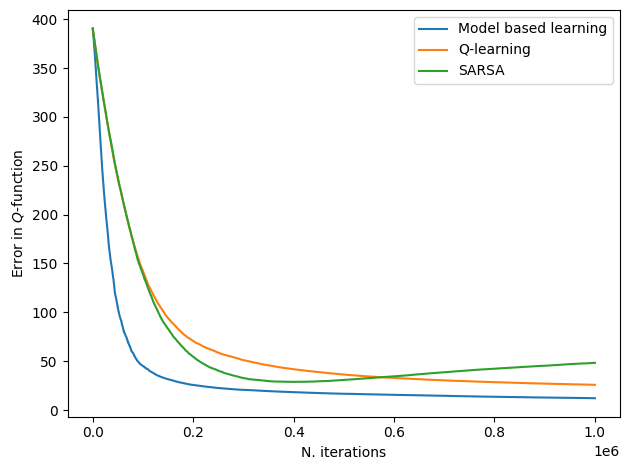

In [65]:
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import trange

STEPS = 100
ITERS = 10000
RUNS  = 5

iters = range(0, STEPS * ITERS + 1, STEPS)

# Error matrices
Emb = np.zeros(ITERS + 1)
Eql = np.zeros(ITERS + 1)
Ess = np.zeros(ITERS + 1)

Emb[0] = np.linalg.norm(Qopt) * RUNS
Eql[0] = Emb[0]
Ess[0] = Emb[0]

rnd.seed(42)

for n in range(RUNS):
    
    print('\n = Training (run n. %i) =' % n)

    # Initialization
    pmb = ()
    for a in range(len(M[1])):
        pmb += (np.eye(len(M[0])),)
    cmb = np.zeros((len(M[0]), len(M[1])))
    qmb = np.zeros((len(M[0]), len(M[1])))

    qql = np.zeros((len(M[0]), len(M[1])))

    qss = np.zeros((len(M[0]), len(M[1])))

    # Run evaluation
    for t in trange(ITERS):
        qmb, pmb, cmb = mb_learning(M, STEPS, qmb, pmb, cmb)
        Emb[t + 1] += np.linalg.norm(Qopt - qmb)

        qql = qlearning(M, STEPS, qql)
        Eql[t + 1] += np.linalg.norm(Qopt - qql)

        qss = sarsa(M, STEPS, qss)
        Ess[t + 1] += np.linalg.norm(Qopt - qss)
        
Emb /= RUNS
Eql /= RUNS
Ess /= RUNS

plt.figure()
plt.plot(iters, Emb, label='Model based learning')
plt.plot(iters, Eql, label='Q-learning')
plt.plot(iters, Ess, label='SARSA')
plt.legend()
plt.xlabel('N. iterations')
plt.ylabel('Error in $Q$-function')
plt.tight_layout()

You can also run the following code, to compare the performance of the three methods:

```python
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import trange

STEPS = 100
ITERS = 10000
RUNS  = 5

iters = range(0, STEPS * ITERS + 1, STEPS)

# Error matrices
Emb = np.zeros(ITERS + 1)
Eql = np.zeros(ITERS + 1)
Ess = np.zeros(ITERS + 1)

Emb[0] = np.linalg.norm(Qopt) * RUNS
Eql[0] = Emb[0]
Ess[0] = Emb[0]

rnd.seed(42)

for n in range(RUNS):
    
    print('\n = Training (run n. %i) =' % n)

    # Initialization
    pmb = ()
    for a in range(len(M[1])):
        pmb += (np.eye(len(M[0])),)
    cmb = np.zeros((len(M[0]), len(M[1])))
    qmb = np.zeros((len(M[0]), len(M[1])))

    qql = np.zeros((len(M[0]), len(M[1])))

    qss = np.zeros((len(M[0]), len(M[1])))

    # Run evaluation
    for t in trange(ITERS):
        qmb, pmb, cmb = mb_learning(M, STEPS, qmb, pmb, cmb)
        Emb[t + 1] += np.linalg.norm(Qopt - qmb)

        qql = qlearning(M, STEPS, qql)
        Eql[t + 1] += np.linalg.norm(Qopt - qql)

        qss = sarsa(M, STEPS, qss)
        Ess[t + 1] += np.linalg.norm(Qopt - qss)
        
Emb /= RUNS
Eql /= RUNS
Ess /= RUNS

plt.figure()
plt.plot(iters, Emb, label='Model based learning')
plt.plot(iters, Eql, label='Q-learning')
plt.plot(iters, Ess, label='SARSA')
plt.legend()
plt.xlabel('N. iterations')
plt.ylabel('Error in $Q$-function')
plt.tight_layout()
```

**Note:** The code above takes a while to conclude. If you want to observe faster results, you may try with a single run (set `RUNS = 1` above) or decrease the training time (changing `ITERS` above). However, the plot you will obtain will differ from the one provided.

As the output, you should observe a plot similar to the one below.

<img src="plot.png" align="left">

---

#### Activity 6.

**Based on the results you obtained when running the above code with your algorithms**, discuss the differences observed between the performance of the three methods.

---

We can see that all algorithm plots reach an error close to 0, and thus learn the optimal policy.
We also see that the model-based algorithm has the lowest error in the end. It updates the model directly, learning the probabilities and costs of the MDP. This leads to a more accurate Q-function, since it's the same method that is used to generate the optimal Q-function trough Value Iteration.
We can also verify that Q-learning and SARSA have similar performance in the beginning. This is expected, as both are temporal diference algorithms.
Also we can see that SARSA tends to increase in the end. This may happen since it's an on-policy algorithm, and the policy may not be optimal. This is not the case for Q-learning, which is an off-policy algorithm.